In [10]:
# Results overview from different methods
import pandas as pd
import pickle as pkl
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path

# Sample results data (parsed from the raw CSV format)
results_data = {
    "CFM": "../outputs/901cf9008660/n_steps=10,n_epochs=500",
    "DFM": "../outputs/eba8ac7722e4/n_steps=10,n_epochs=500", 
    "DCB": "../outputs/fd4b27770d16/n_steps=10,n_epochs=500"
}


Loaded CFM: shape (11, 10000, 2)
Loaded DFM: shape (11, 10000, 2)
Loaded DCB: shape (11, 10000, 2)


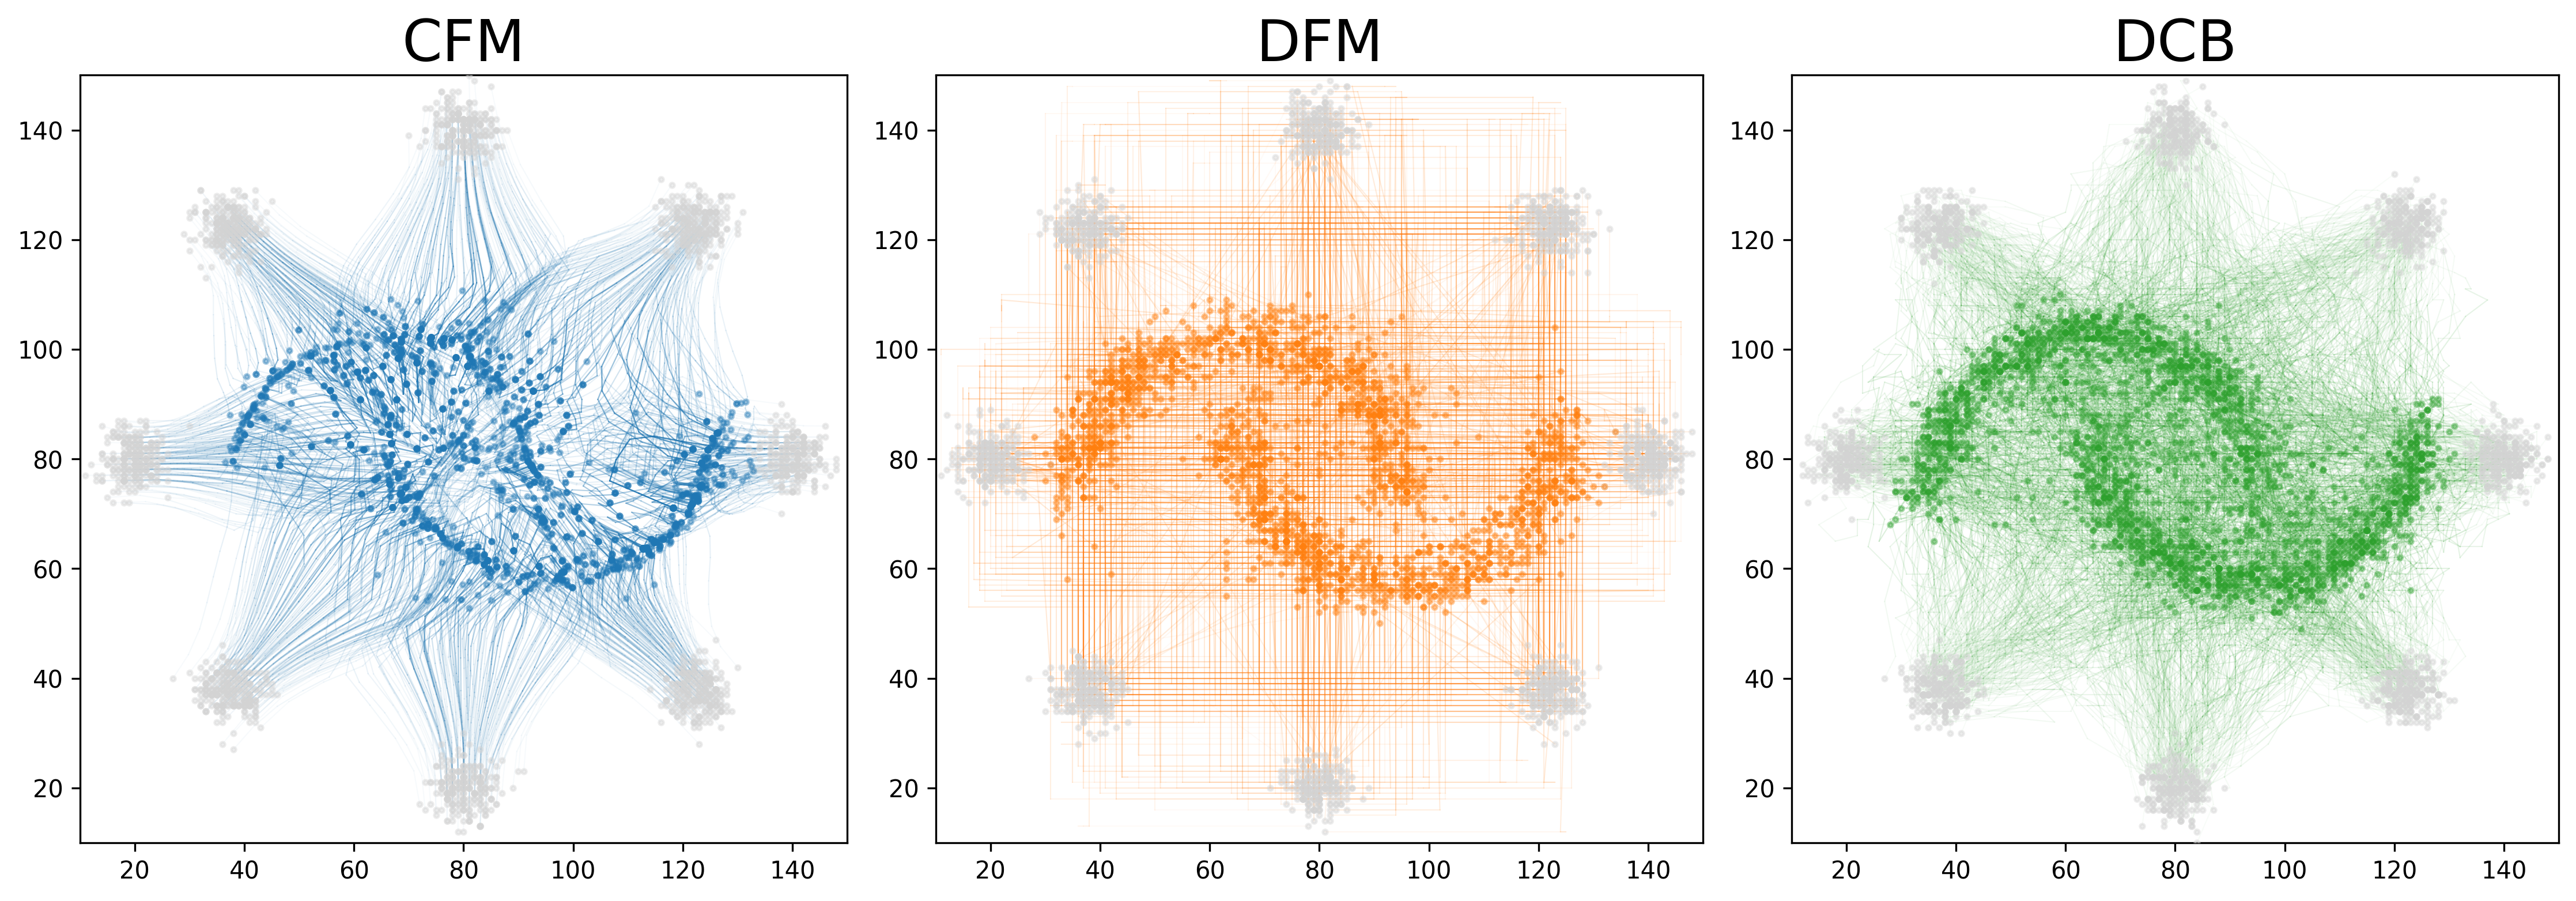

Trajectory plot saved to: figs/trajectory_comparison.png


In [11]:
def load_trajectory_data():
    """Load trajectory data for all methods."""
    trajectories = {}
    
    for method, path in results_data.items():
        try:
            cache_file = f"{path}/evaluation_cache.pkl"
            data = pkl.load(open(cache_file, "rb"))
            trajectories[method] = data['eval_data']['x_trajectory']
            print(f"Loaded {method}: shape {trajectories[method].shape}")
        except Exception as e:
            print(f"Could not load {method}: {e}")
    
    return trajectories

def create_beautiful_trajectory_plot(trajectories, save_path="figs/trajectory_comparison.png"):
    """Create a beautiful trajectory visualization."""
    
    # Set up the figure with subplots
    fig = plt.figure(figsize=(15, 5), dpi=300)
    
    # Color scheme matching your other plots
    colors = {"CFM": "#1f77b4", "DFM": "#ff7f0e", "DCB": "#2ca02c"}
    
    # Create subplots for each method
    for i, (method, traj) in enumerate(trajectories.items()):
        ax = fig.add_subplot(1, len(trajectories), i+1)
        
        # Sample some particles to avoid overcrowding
        n_particles = min(2_000, traj.shape[1])  # Show max 500 particles
        sample_idx = np.random.choice(traj.shape[1], n_particles, replace=False)
        
        # Plot trajectories with gradient colors
        for t in range(len(traj) - 1):
            # Current and next positions
            x_curr = traj[t, sample_idx, 0]
            y_curr = traj[t, sample_idx, 1]
            x_next = traj[t+1, sample_idx, 0]
            y_next = traj[t+1, sample_idx, 1]
            
            # Color intensity based on time step
            alpha = 0.1 + 0.5 * (t / (len(traj) - 1))  # Fade from light to dark
            
            # Plot trajectory segments
            for j in range(len(x_curr)):
                ax.plot([x_curr[j], x_next[j]], [y_curr[j], y_next[j]], 
                       color=colors[method], alpha=alpha*0.3, linewidth=0.5)
        
        # Highlight start and end points
        start_points = traj[0, sample_idx]
        end_points = traj[-1, sample_idx]
        
        # Starting points (lighter, larger)
        ax.scatter(start_points[:, 0], start_points[:, 1], 
                  c='lightgray', s=4, alpha=0.4, label='Start', zorder=3)
        
        # End points (method color, smaller)
        ax.scatter(end_points[:, 0], end_points[:, 1], 
                  c=colors[method], s=4, alpha=0.4, label='End', zorder=4)
        
        # Styling
        ax.set_title(f"{method}", fontsize=24)
        ax.set_aspect('equal')
        # ax.grid(True, alpha=0.3)
        ax.set_xlim(10, 150)
        ax.set_ylim(10, 150)
    
    plt.tight_layout()
    
    # Save the plot
    Path("figs").mkdir(exist_ok=True)
    plt.savefig(save_path, bbox_inches='tight', facecolor='white')
    plt.show()
    print(f"Trajectory plot saved to: {save_path}")

# Load and plot
trajectories = load_trajectory_data()
if trajectories:
    create_beautiful_trajectory_plot(trajectories)


In [2]:
import pandas as pd

def create_clean_discrete_moons_table():
    """Create a clean LaTeX table matching the style of the main table notebook."""
    
    # Load the results CSV
    df = pd.read_csv("comparison/DiscreteMoonsDataset_dim2_51be9fc4.csv")
    
    # Available metrics (matching the main table style)
    metrics = {
        "mmd_rbf": ("mmd_rbf_mean", "mmd_rbf_std", "MMD"),
        "wasserstein": ("wasserstein_distance_mean", "wasserstein_distance_std", "$W_2$"),
        "energy": ("energy_distance_mean", "energy_distance_std", "Energy")
    }
    
    # Create tables directory
    Path("tables").mkdir(exist_ok=True)
    
    # Show all methods with clean names
    method_mapping = {
        'CFMBridge_MSELoss': 'CFM',
        'DiscreteFlowBridge_CrossEntropyLoss': 'DFM', 
        'SkellamBridge_CrossEntropyLoss': 'Count Bridge (CE)',
        'SkellamBridge_EnergyScoreLoss': 'Count Bridge (ES)',
        'SkellamBridge_MSELoss': 'Count Bridge (MSE)'
    }
    
    # Use all methods in the CSV
    selected_methods = method_mapping
    
    # Generate LaTeX table
    lines = []
    lines.append("\\begin{table}[h!]")
    lines.append("\\centering")
    lines.append("\\caption{Discrete Moons Results: Eight Gaussians → Two Moons}")
    lines.append("\\label{tab:discrete_moons}")
    lines.append("\\begin{tabular}{l" + "c" * len(metrics) + "}")
    lines.append("\\toprule")
    
    # Header
    header = ["Method"] + [display_name for _, (_, _, display_name) in metrics.items()]
    lines.append(" & ".join(header) + " \\\\")
    lines.append("\\midrule")
    
    # Find best values for each metric across ALL methods
    best_values = {}
    for metric_key, (mean_col, _, _) in metrics.items():
        best_values[metric_key] = df[mean_col].min()
    
    # Data rows - show selected methods only
    for method_id, method_name in selected_methods.items():
        method_row = df[df['method'] == method_id].iloc[0]
        
        row_data = [method_name]
        
        for metric_key, (mean_col, std_col, _) in metrics.items():
            mean_val = method_row[mean_col]
            std_val = method_row[std_col]
            
            # Format mean and std values
            if mean_val < 0.001:
                formatted_mean = f"{mean_val:.2e}"
                formatted_std = f"{std_val:.2e}"
            elif mean_val < 0.01:
                formatted_mean = f"{mean_val:.4f}"
                formatted_std = f"{std_val:.4f}"
            elif mean_val < 1:
                formatted_mean = f"{mean_val:.3f}"
                formatted_std = f"{std_val:.3f}"
            else:
                formatted_mean = f"{mean_val:.2f}"
                formatted_std = f"{std_val:.2f}"
            
            # Combine mean ± std
            formatted_val = f"{formatted_mean} ± {formatted_std}"
            
            # Bold if best value across all methods
            if abs(mean_val - best_values[metric_key]) < 1e-10:
                formatted_val = f"\\textbf{{{formatted_val}}}"
                
            row_data.append(formatted_val)
        
        lines.append(" & ".join(row_data) + " \\\\")
    
    lines.append("\\bottomrule")
    lines.append("\\end{tabular}")
    lines.append("\\end{table}")
    lines.append("")
    lines.append("% Note: Bold values indicate best performance (lowest) across all methods.")
    lines.append("% CE = CrossEntropyLoss, ES = EnergyScoreLoss, MSE = MSELoss")
    lines.append("% Metrics: MMD = Maximum Mean Discrepancy, W_2 = 2-Wasserstein Distance")
    
    # Save to file
    filename = Path("tables/discrete_moons_results.tex")
    with open(filename, 'w') as f:
        f.write('\n'.join(lines))

    print(f"Table saved to: {filename}")
    

# Create the clean LaTeX table
results = create_clean_discrete_moons_table()


FileNotFoundError: [Errno 2] No such file or directory: 'comparison/DiscreteMoonsDataset_dim2_51be9fc4.csv'